In [240]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import date_range
from pandas.io.json import json_normalize

In [3]:
raw_train = pd.read_csv("../data/train_df_v2.csv")

/Users/chloe/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
raw_train = raw_train.drop(['Unnamed: 0', 'customDimensions', 'hits'], axis=1)

In [99]:
cols = list(raw_train.columns)
cols.remove('trafficSource.campaignCode')    # Test set does not contain campaignCode

In [100]:
raw_test = pd.read_csv("../data/test_df_v2.csv", usecols = cols)

/Users/chloe/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
raw_train.shape # (1708337, 58)
raw_test.shape # (401589, 57)      # No trafficSource.campaignCode

(401589, 57)

In [80]:
raw_train.shape

(1708337, 58)

In [142]:
train_df = raw_train.copy()
test_df = raw_test.copy()
raw_names = list(raw_train.columns)

In [143]:
new_cols = []
for col in train_df.columns:
    newCol = col
    if col == 'channelGrouping':
        newCol = 'channel'
    elif col == 'fullVisitorId':
        newCol = 'Id'
    elif col == 'totals.transactionRevenue':     # This column means transaction per session
        newCol = 'revenue'                            # which is what we are going to predict
    elif col == 'totals.totalTransactionRevenue':          # this column means transaction per ID
        newCol = 'totalRevenue'
    elif col.startswith('socialEngagementType'):
        newCol = col.replace('socialEngagementType','social')
    elif col.startswith('device'):
        newCol = col.replace('device','d')
    elif col.startswith('geoNetwork'):
        newCol = col.replace('geoNetwork','g')
    elif col.startswith('trafficSource'):
        newCol = col.replace('trafficSource','t')
    new_cols.append(newCol)

train_df.columns = new_cols
new_cols.remove('t.campaignCode')
test_df.columns = new_cols
raw_cols = list(raw_train.columns)

In [116]:
# Check renamed columns names.
train_df.columns

Index(['channel', 'date', 'Id', 'social', 'visitId', 'visitNumber',
       'visitStartTime', 'd.browser', 'd.browserSize', 'd.browserVersion',
       'd.dCategory', 'd.flashVersion', 'd.isMobile', 'd.language',
       'd.mobileDeviceBranding', 'd.mobileDeviceInfo',
       'd.mobileDeviceMarketingName', 'd.mobileDeviceModel',
       'd.mobileInputSelector', 'd.operatingSystem',
       'd.operatingSystemVersion', 'd.screenColors', 'd.screenResolution',
       'g.city', 'g.cityId', 'g.continent', 'g.country', 'g.latitude',
       'g.longitude', 'g.metro', 'g.networkDomain', 'g.networkLocation',
       'g.region', 'g.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'revenue', 'totalRevenue', 'totals.transactions',
       'totals.visits', 't.adContent', 't.adwordsClickInfo.adNetworkType',
       't.adwordsClickInfo.criteriaParameters', 't.adwordsClickInfo.gclId',
       't.adwordsClickInfo.

### Missing value

In [84]:
# Check missing value
def get_na_rate(dataframe):
    na_count = dataframe.isnull().sum()
    na_rate = na_count / len(dataframe)
    na_df = pd.concat([na_count, na_rate], axis=1, keys=['count', 'percent'])
    na_df = na_df[na_df['percent']>0]
    na_df = na_df.sort_values(['percent'], ascending=False)
    return na_df

na_df = get_na_rate(train_df)
na_df

,count,percent
t.campaignCode,1708336,0.999999
revenue,1689823,0.989163
totalRevenue,1689823,0.989163
totals.transactions,1689778,0.989136
t.adContent,1643600,0.962105
t.adwordsClickInfo.adNetworkType,1633063,0.955937
t.adwordsClickInfo.isVideoAd,1633063,0.955937
t.adwordsClickInfo.slot,1633063,0.955937
t.adwordsClickInfo.page,1633063,0.955937
t.adwordsClickInfo.gclId,1632914,0.955850


In [144]:
# Fill NA value in revenue with 0
fillZero_list = []
fillZero_list.extend(['revenue','totalRevenue'])

# totals.transaction contains similar information with revenue. Drop it.
drop_list = []
drop_list.append('totals.transactions')

# t.campaignCode, t.adContent, t.adwords... contain more than 90% of NA Value
# Drop them
train_df['t.isAdwords'] = train_df['t.adwordsClickInfo.adNetworkType'].notnull().astype(int) 
drop_list.extend(['t.campaignCode','t.adContent','t.adwordsClickInfo.adNetworkType',
                         't.adwordsClickInfo.isVideoAd','t.adwordsClickInfo.page',
                          't.adwordsClickInfo.slot','t.adwordsClickInfo.gclId'])

# fill NAs in t.isTrueDirect with False
train_df['t.isTrueDirect'] = train_df['t.isTrueDirect'].notnull().astype(int)

# The referral path has too many scattered value, create another value to represent its exsistence.
train_df['t.isReferralPath'] = train_df['t.referralPath'].notnull().astype(int)  
train_df['t.isKeyword'] = train_df['t.keyword'].notnull().astype(int) 
drop_list.extend(['t.referralPath','t.keyword'])

# Fill NAs in totals.timeOnsite and totals.sessionQualityDim with zero
fillZero_list.extend(['totals.timeOnSite','totals.sessionQualityDim'])

# According to the bounce's definition: "It represents the percentage of visitors who 
# enter the site and then leave ("bounce") rather than continuing to view other pages 
# within the same site."
# Fill NA value with 0.
fillZero_list.append('totals.bounces')

# Same way to deal with the NA value in totals.newVisits.
fillZero_list.append('totals.newVisits')

# Fill NA value in pageviews with median.
train_df['totals.pageviews'] = train_df['totals.pageviews'].fillna(train_df['totals.pageviews'].median())

train_df = train_df.drop(drop_list,axis=1)
for col in fillZero_list:
    train_df[col] = train_df[col].fillna(0)


In [90]:
# Check again if there is any missing value
get_na_rate(train_df)

,count,percent


In [117]:
train_id = list(set(train_df['Id'])) # 1371486 unique ID in training set
test_id = list(set(test_df['Id']))   # 300364 unique ID in training set
inter_id = list(set(train_id).intersection(test_id)) # Only 2623 test IDs are in train's ID list

In [91]:
train_df.iloc[:,8:].describe()

,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,revenue,totalRevenue,totals.visits,t.isTrueDirect,t.isAdwords,t.isReferralPath,t.isKeyword
count,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1708337.0,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06
mean,5.101909e-01,4.429598e+00,7.653232e-01,3.695825e+00,1.915779e+00,1.238619e+02,1.547767e+06,1.355906e+06,1.0,3.128879e-01,4.406273e-02,3.314709e-01,3.837399e-01
std,4.998963e-01,8.991748e+00,4.237968e-01,6.472863e+00,8.334279e+00,3.544553e+02,6.881097e+07,4.522809e+07,0.0,4.636693e-01,2.052346e-01,4.707420e-01,4.862959e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,4.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,7.600000e+01,0.000000e+00,0.000000e+00,1.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,1.000000e+00,5.000000e+02,1.000000e+00,5.000000e+02,1.000000e+02,1.901700e+04,4.708206e+10,2.312950e+10,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [121]:
cols_unique = train_df.columns[train_df.nunique(dropna=False)==1]
cols_unique

Index(['social', 'd.browserSize', 'd.browserVersion', 'd.flashVersion',
       'd.language', 'd.mobileDeviceBranding', 'd.mobileDeviceInfo',
       'd.mobileDeviceMarketingName', 'd.mobileDeviceModel',
       'd.mobileInputSelector', 'd.operatingSystemVersion', 'd.screenColors',
       'd.screenResolution', 'g.cityId', 'g.latitude', 'g.longitude',
       'g.networkLocation', 'totals.visits',
       't.adwordsClickInfo.criteriaParameters'],
      dtype='object')

In [153]:
# Drops columns with unique values
train_df = train_df.drop(cols_unique, axis=1)  #(1708337, 39)

In [154]:
train_df.columns

Index(['channel', 'date', 'Id', 'visitId', 'visitNumber', 'visitStartTime',
       'd.browser', 'd.dCategory', 'd.isMobile', 'd.operatingSystem', 'g.city',
       'g.continent', 'g.country', 'g.metro', 'g.networkDomain', 'g.region',
       'g.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits',
       'totals.pageviews', 'totals.sessionQualityDim', 'totals.timeOnSite',
       'totalRevenue', 'revenue', 't.campaign', 't.isTrueDirect', 't.medium',
       't.source', 't.isAdwords', 't.isReferralPath', 't.isKeyword'],
      dtype='object')

### Revenue

/Users/chloe/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chloe/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of revenue > 0')

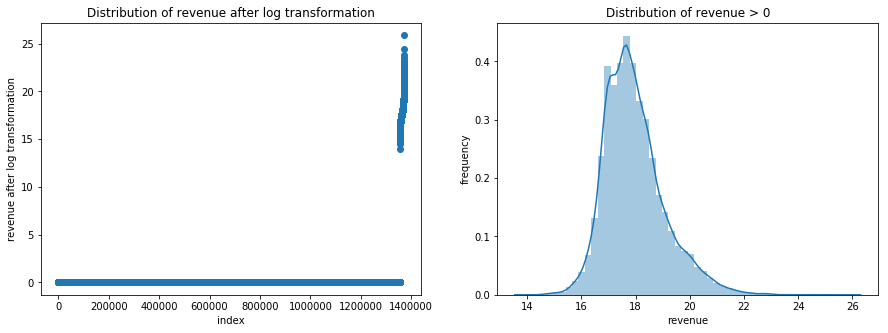

In [128]:
# Have a look at the revenue which is what we are going to predict
# From the graph, we can see there is a clear pattern which is consistent
# with the 80/20 rule.
plt.subplots(ncols=2, figsize=(15,5))
plt.subplot(121)
revenue = train_df.groupby('Id')['revenue'].sum().reset_index()
revenue['revenue'] = np.log1p(revenue['revenue'].values) # takes natural log of revenue as is required in the competition
plt.scatter(range(revenue.shape[0]),np.sort(revenue['revenue']))
plt.xlabel('index')
plt.ylabel('revenue after log transformation')
plt.title('Distribution of revenue after log transformation')
plt.subplot(122)
sns.distplot(revenue[revenue['revenue']>1]['revenue'])
plt.ylabel('frequency')
plt.title('Distribution of revenue > 0')

In [182]:
id_nonzero = set(train_df[train_df['revenue'] != 0]['Id']) # 16584 visitors who actually did make transactions
id_zero = set(train_df[train_df['revenue'] == 0]['Id'])-id_nonzero  # 1354902 visitors who didn't make any transaction
nonzero_df = train_df[train_df['revenue'] != 0]  # 18514
zero_df = train_df[train_df['revenue'] == 0]     # 1689823
train_df['revenue'].astype(bool).sum(axis=0)/len(train_df) # Only 1.08% of visitor makes transaction.

0.010837440153786987

### channelGrouping

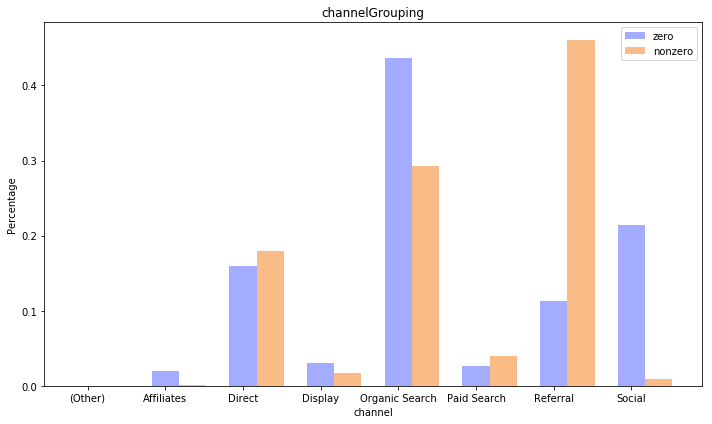

In [150]:
# Top 3 channels for visitors with revenue: Referral, Organic search and Direct.
# Top 3 channels for visitors with no revenue: Organic search, Social and Direct.
# Referal plays an important role in differentiating the visitors.

def plot_two_groups(column):
    channel_zero = zero_df.groupby(column)[column].count()/len(zero_df)
    channel_nonzero = nonzero_df.groupby(column)[column].count()/len(nonzero_df)
    ind = np.arange(len(channel_zero))
    width = 0.35
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.bar(ind, channel_zero, width=0.35,  color='#a3acff', label='zero')
    ax.bar(ind+width, channel_nonzero, width=0.35, color='#f9bc86', label='nonzero')
    title = raw_train.columns[col_names.index(column)]
    plt.xticks(ind, channel_zero.index)
    plt.xlabel(column)
    plt.ylabel('Percentage')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_two_groups('channel')

### Device

In [155]:
device_cols = [col for col in train_df.columns if col.startswith('d.')and col not in cols_unique]
device_cols

['d.browser', 'd.dCategory', 'd.isMobile', 'd.operatingSystem']

#### Device.browser

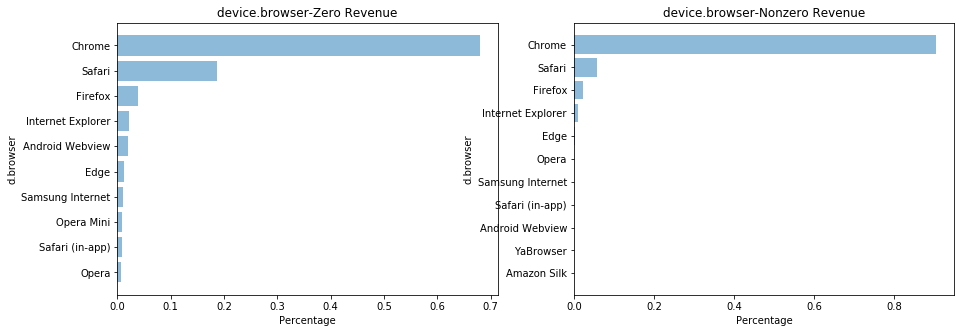

In [156]:
# Visitors with zero revenue and non-zero revenue share the same top 3 frequently used browsers.
# While visitors with zero revenue tends to have a higher tendency of using the these browsers.
def plot_diff_groups(column, k_zero=0, k_nonzero=0):     # k_zero, k_nonzero: top k classes to be displayed.
    browser_zero = zero_df.groupby(column)[column].count().sort_values()/len(zero_df)
    browser_nonzero = nonzero_df.groupby(column)[column].count().sort_values()/len(nonzero_df)
    title = raw_train.columns[col_names.index(column)]
    plt.subplots(ncols=2, figsize=(15,5))
    plt.subplot(121)
    plt.barh(browser_zero.index[-k_zero:], browser_zero[-k_zero:], align='center', alpha=0.5)
    plt.xlabel('Percentage')
    plt.ylabel(column)
    plt.title(title+"-Zero Revenue")
    plt.subplot(122)
    plt.barh(browser_nonzero.index[-k_nonzero:], browser_nonzero[-k_nonzero:], align='center', alpha=0.5)
    plt.xlabel('Percentage')
    plt.ylabel(column)
    plt.title(title+"-Nonzero Revenue")
    plt.show()
plot_diff_groups('d.browser',10)

#### Device.deviceCategory

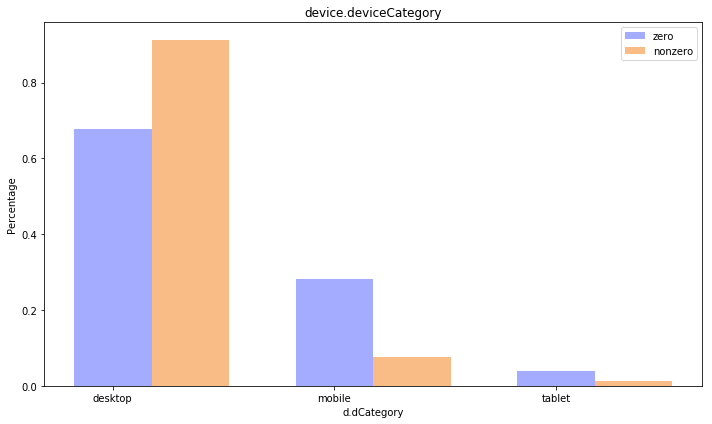

In [157]:
# Both visitors groups use desktop to access the Store most frequently.
# Visitors with revenue have a higher tendency of using desktop.

plot_two_groups('d.dCategory')

#### Device.isMobile

In [158]:
# Visitors who actually made transactions prefered not to use the mobile phone to access the Store.

train_df['isRevenue'] = raw_train['totals.transactionRevenue'].notnull().astype(int)
binary_table = train_df.groupby('isRevenue').sum()
binary_table.iloc[0,:] = binary_table.iloc[0,:]/len(zero_df)
binary_table.iloc[1,:] = binary_table.iloc[1,:]/len(nonzero_df)
binary_table['d.isMobile']

isRevenue
0    0.323182
1    0.030506
Name: d.isMobile, dtype: float64

#### Device.operatingSystem

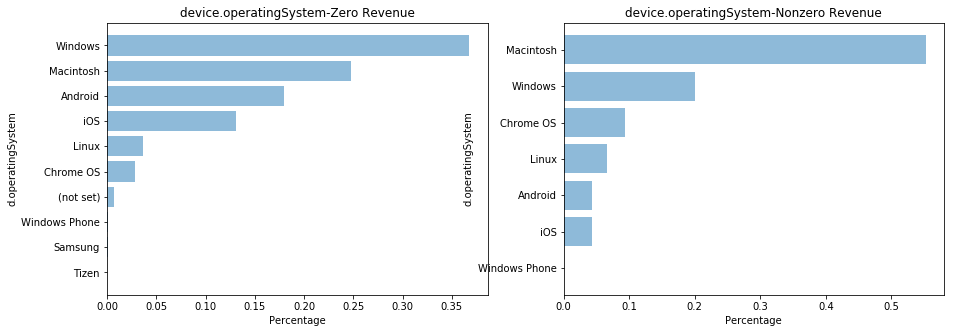

In [159]:
# Top 3 operating systems for visitors with no revenue: Windows, Mac and Android.
# Top 3 channels for visitors with revenue: Mac, Windows and Chrome OS.
# More than half of the visitors with revenue used mac to access Store.

plot_diff_groups('d.operatingSystem',10)

### geoNetwork

In [162]:
geo_cols = [col for col in train_df.columns if col.startswith('g.')and col not in cols_unique]
geo_cols

['g.city',
 'g.continent',
 'g.country',
 'g.metro',
 'g.networkDomain',
 'g.region',
 'g.subContinent']

In [ ]:
# All the plots can be shown together with the commands below.
# In order to look at each column in detail, I will plot them one by one.
#for item in geo_cols:
#    plot_diff_groups(item,10,10)

#### geoNetwork.city

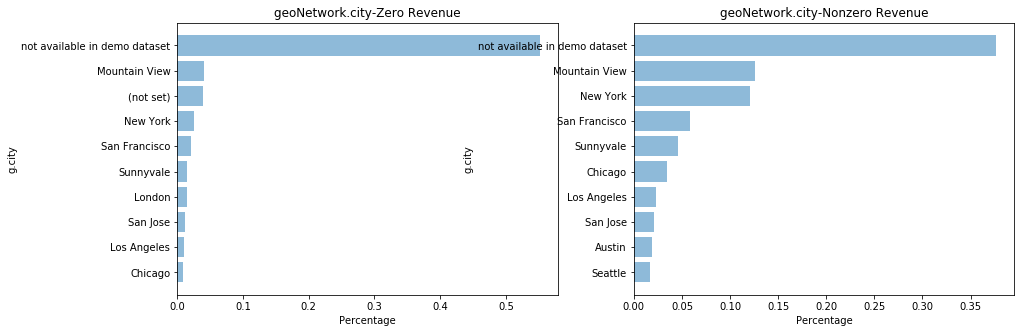

In [163]:
# Not much to tell from the two graphs because the majority of records are not available.
# New York and Mountain View are two major cities where the visitors making transactions come from among all the cities.

plot_diff_groups('g.city',10,10)

#### geoNetwork.continent

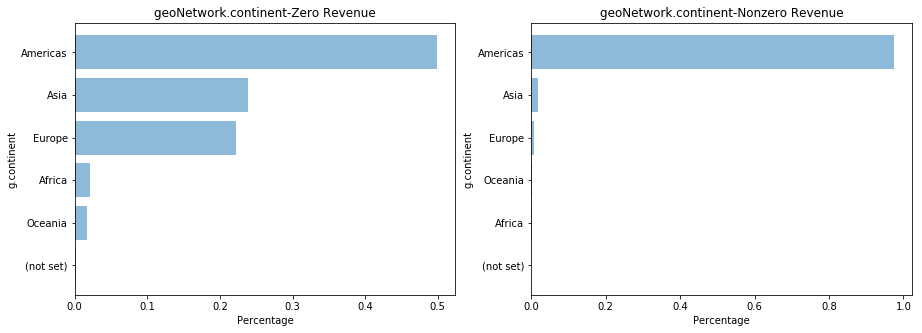

In [165]:
# It is not suprised to see that almost all the visitors who made transactions are Americas.
# Although many Asian and European people also visit the stores, they seldomly made purchase.

plot_diff_groups('g.continent')

#### geoNetwork.country

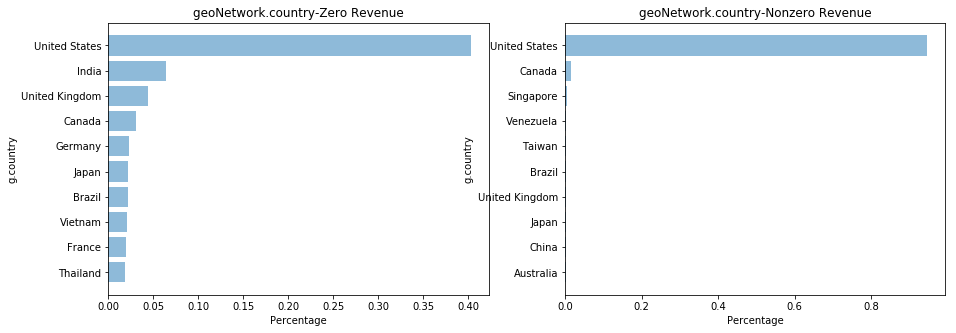

In [166]:
# Most of visitors who made purchase are from US which is consistent with the continent.

plot_diff_groups('g.country',10,10)

#### geoNetwork.networkDomain

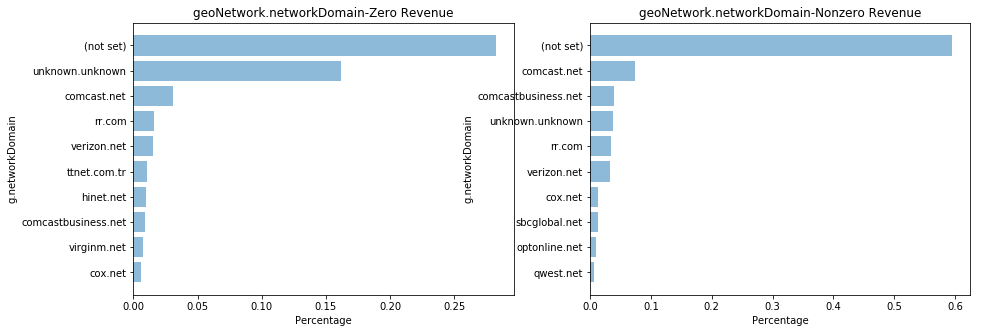

In [167]:
# Not much to tell from these two graphs.

plot_diff_groups('g.networkDomain',10,10)

#### geoNetwork.metro

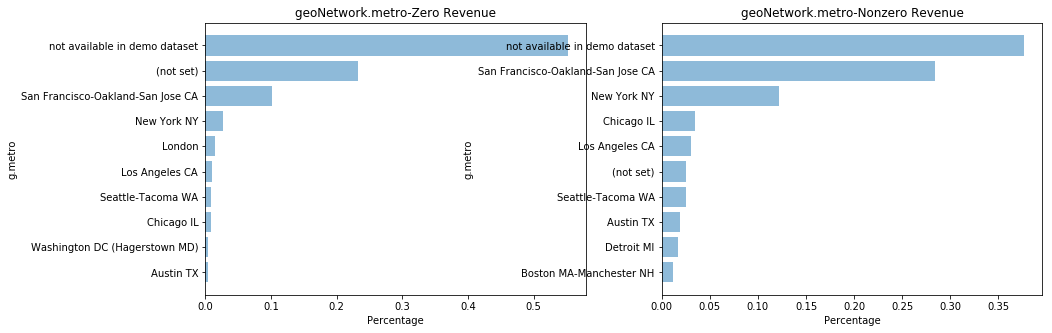

In [168]:
# The result is consistent with what we found in the city. Bay area and New York are the two major areas where visitors
# making purchases came from in the available dataset.

plot_diff_groups('g.metro',10,10)

#### geoNetwork.subContinent

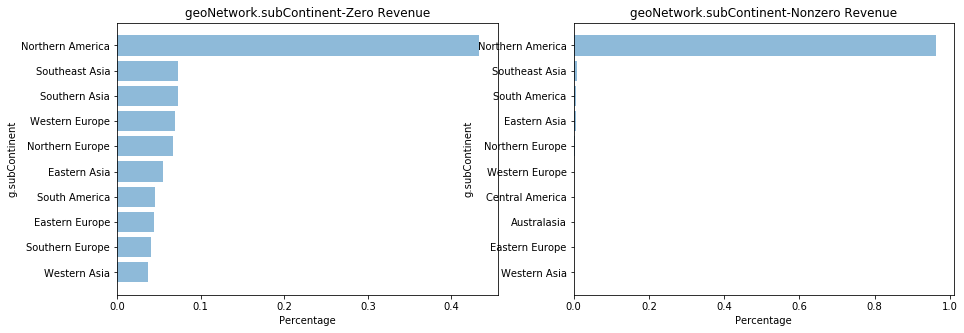

In [169]:
# Not much to tell.

plot_diff_groups('g.subContinent',10,10)

### Traffic

In [170]:
# Most of traffic's variables have either contant value or too many missing value (more than 90%).
traffic_cols = [col for col in train_df.columns if col.startswith('t.')and col not in cols_unique]
traffic_cols

['t.campaign',
 't.isTrueDirect',
 't.medium',
 't.source',
 't.isAdwords',
 't.isReferralPath',
 't.isKeyword']

#### traffic.campaign

In [172]:
# Both groups have a majority of "not set" (more than 90%)

campaign_zero = zero_df.groupby('t.campaign')['t.campaign'].count()/len(zero_df)
campaign_nonzero = nonzero_df.groupby('t.campaign')['t.campaign'].count()/len(nonzero_df)

#### traffic.isTrueDirect, isAdwords, isReferralPath and isKeyword

In [173]:
# The percentage of traffic source which is direct, have adwords, is referral path is higher
# in visitors making purchase than that in visitors with no revenue.
# The visitors with no revenue have a higher percentage of traffic source containing keyword.

binary_table[['t.isTrueDirect','t.isAdwords','t.isReferralPath','t.isKeyword']]

,t.isTrueDirect,t.isAdwords,t.isReferralPath,t.isKeyword
isRevenue,,,,
0,0.316002,0.045067,0.336748,0.393189
1,0.215133,0.012532,0.165839,0.087138


#### traffic.medium

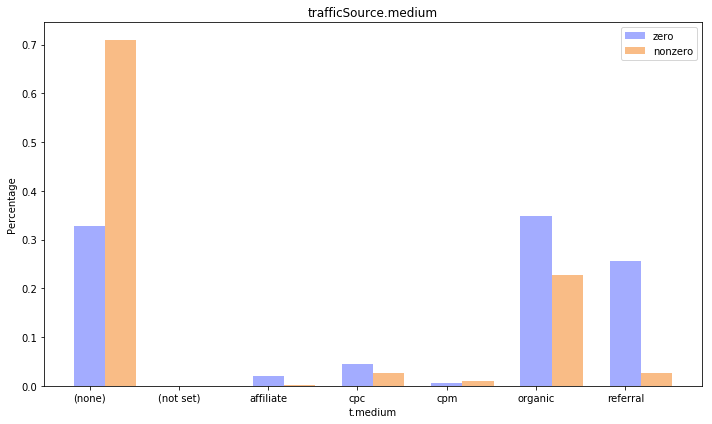

In [183]:
# Visitors who actually made purchase or not have a high percentage of "None" in medium.

plot_two_groups('t.medium')

#### traffic.source

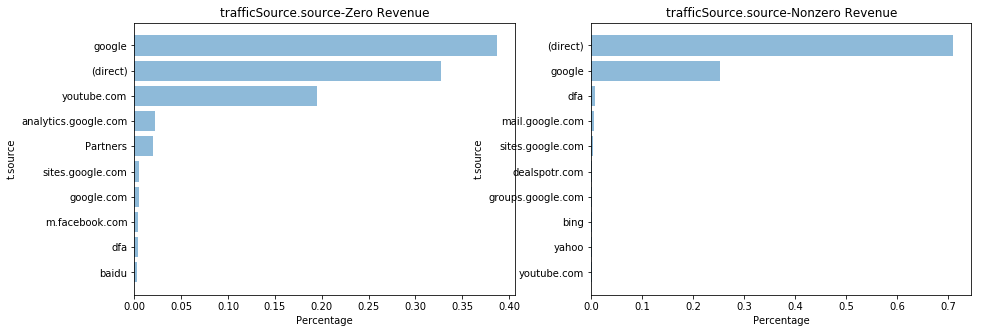

In [184]:
# There is a large difference in the traffic sources of two groups
# Top 3 sources for visitors with no revenue: google, youtube and direct
# Top 3 sources for visitors with revenue: mail.googleplex.com, google and direct
# It is interesting to see that nearly half of the visitors who made transaction got the source from mail.googleplex.com.
# Are these visitors are actually Google people themselves? 

# In new datasets, there is no longer mail.googleplex.com in the source.
plot_diff_groups('t.source',10,10)

In [188]:
# Weird
train_df[train_df['t.source'] == 'mail.googleplex.com']

,channel,date,Id,visitId,visitNumber,visitStartTime,d.browser,d.dCategory,d.isMobile,d.operatingSystem,...,totalRevenue,revenue,t.campaign,t.isTrueDirect,t.medium,t.source,t.isAdwords,t.isReferralPath,t.isKeyword,isRevenue


### Totals

In [185]:
total_cols = [col for col in train_df.columns if col.startswith('totals.')and col not in cols_unique]
total_cols

['totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'totals.sessionQualityDim',
 'totals.timeOnSite']

#### totals.bounces, totals.newVisits

In [186]:
# It is obvious that visitors who make purchase would not leave the site without viewing
# pages.
# More visitors with no revenue are new visitors.

binary_table[['totals.bounces','totals.newVisits']]

,totals.bounces,totals.newVisits
isRevenue,,
0,0.526445,0.785305
1,0.000000,0.138120


#### totals.hits

Text(0.5,1,'frequency of hits')

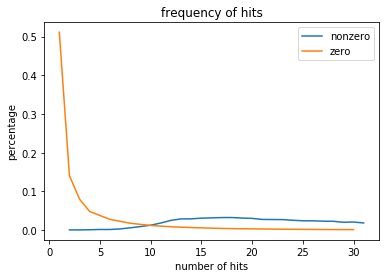

In [221]:
# 1. Check the difference in the frequency of hits between two groups
# It seems that visitors who make purchase hits more
hits_zero_per = zero_df.groupby('totals.hits')['totals.hits'].count()/len(zero_df) # Median: 8.5
hits_nonzero_per = nonzero_df.groupby('totals.hits')['totals.hits'].count()/len(nonzero_df) # Median: 8.0
plt.plot(hits_nonzero_per.index[:30],hits_nonzero_per[:30], label='nonzero')
plt.plot(hits_zero_per.index[:30],hits_zero_per[:30], label='zero')
plt.xlabel('number of hits')
plt.ylabel('percentage')
plt.legend()
plt.title('frequency of hits')

In [190]:
# 2. Check the relatioinship between the revenue and total hits in one session
# Excludes those super large number of hits which only occurs once
hits_nonzero = nonzero_df.groupby('totals.hits')['totals.hits'].count()
hits_more_than_one = hits_nonzero[hits_nonzero > 1].index
hits_more_df  = nonzero_df[nonzero_df['totals.hits'].isin(hits_more_than_one)]
hits_revenue_avg = hits_more_df.groupby('totals.hits')['revenue'].mean()

Text(0.5,1,'avearge reveune (hits < 50)')

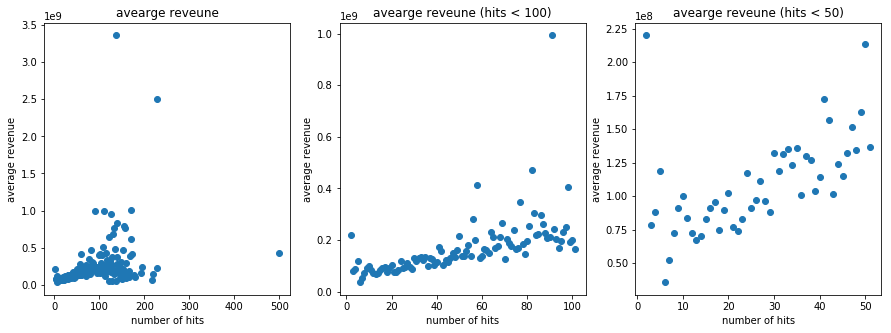

In [191]:
# It can be seen that the revenue tends to increase with the increase in number of hits.

plt.subplots(ncols=3, figsize=(15,5))
plt.subplot(131)
plt.scatter(hits_revenue_avg.index,hits_revenue_avg)
plt.xlabel('number of hits')
plt.ylabel('average revenue')
plt.title('avearge reveune')
plt.subplot(132)
plt.scatter(hits_revenue_avg.index[:100],hits_revenue_avg[:100])
plt.xlabel('number of hits')
plt.ylabel('average revenue')
plt.title('avearge reveune (hits < 100)')
plt.subplot(133)
plt.scatter(hits_revenue_avg.index[:50],hits_revenue_avg[:50])
plt.xlabel('number of hits')
plt.ylabel('average revenue')
plt.title('avearge reveune (hits < 50)')

#### totals.pageviews

Text(0.5,1,'Number of page views vs Total revenue')

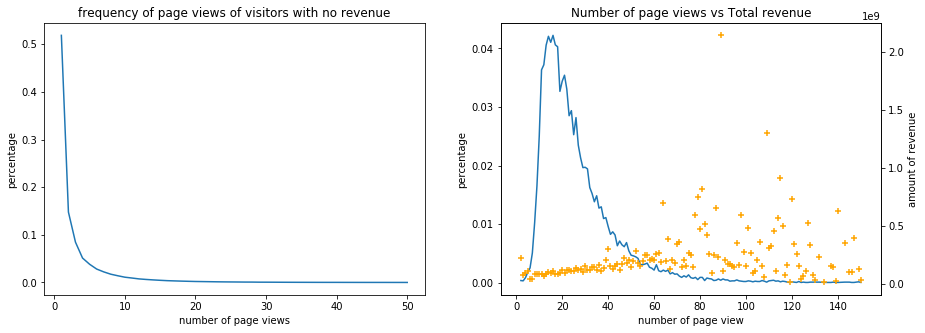

In [229]:
# All the visitors who make purchase view the page more than once
# It seems the number of page view has nothing to do with the revenue.
plt.subplots(ncols=2, figsize=(15,5))
page_zero_per = zero_df.groupby('totals.pageviews')['totals.pageviews'].count()/len(zero_df) 
page_nonzero_per = nonzero_df.groupby('totals.pageviews')['totals.pageviews'].count()/len(nonzero_df) 
page_nonzero_per = page_nonzero_per[:150]
page_revenue = nonzero_df.groupby('totals.pageviews')['revenue'].mean()[:150]
plt.subplot(121)
plt.plot(page_zero_per.index[:50],page_zero_per[:50])
plt.xlabel('number of page views')
plt.ylabel('percentage')
plt.title('frequency of page views of visitors with no revenue')
ax1 = plt.subplot(122)
plt.plot(page_nonzero_per.index,page_nonzero_per)
ax2 = ax1.twinx()
ax2.scatter(page_revenue.index,page_revenue, color='orange',marker='+')
ax1.set_xlabel('number of page view')
ax1.set_ylabel('percentage')
ax2.set_ylabel('amount of revenue')
plt.title("Number of page views vs Total revenue")

#### totals.sessionQualityDim

Text(0.5,1,'session quality dimension vs Total revenue')

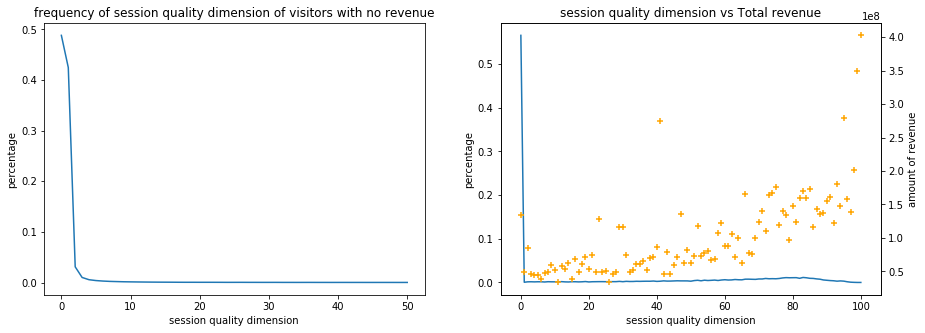

In [211]:
# It seems that visitors tend to make transactions with session quality dimension higher than 10.
plt.subplots(ncols=2, figsize=(15,5))
sqd_zero_per = zero_df.groupby('totals.sessionQualityDim')['totals.sessionQualityDim'].count()/len(zero_df) 
sqd_nonzero_per = nonzero_df.groupby('totals.sessionQualityDim')['totals.sessionQualityDim'].count()/len(nonzero_df) 
sqd_nonzero_per = sqd_nonzero_per[:100]
sqd_revenue = nonzero_df.groupby('totals.sessionQualityDim')['revenue'].mean()[:100]
plt.subplot(121)
plt.plot(sqd_zero_per.index[:51],sqd_zero_per[:50])
plt.xlabel('session quality dimension')
plt.ylabel('percentage')
plt.title('frequency of session quality dimension of visitors with no revenue')
ax1 = plt.subplot(122)
plt.plot(sqd_nonzero_per.index,sqd_nonzero_per)
ax2 = ax1.twinx()
ax2.scatter(sqd_revenue.index,sqd_revenue, color='orange',marker='+')
ax1.set_xlabel('session quality dimension')
ax1.set_ylabel('percentage')
ax2.set_ylabel('amount of revenue')
plt.title("session quality dimension vs Total revenue")

#### totals.timeOnSite

Text(0.5,1,'Time on site vs Total revenue')

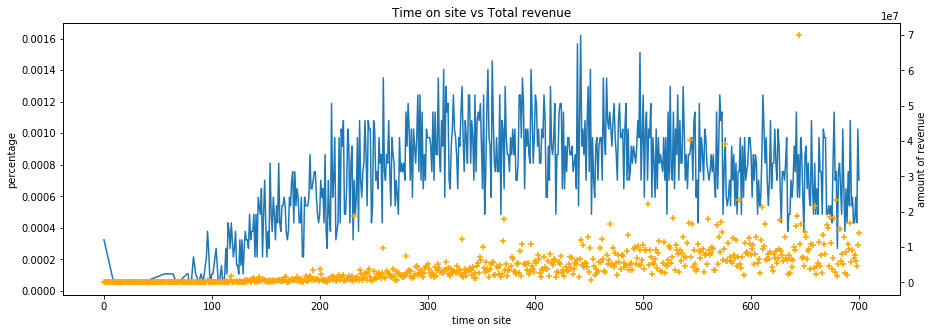

In [237]:
# Visitors who stay on site longer tend to make purchase.
plt.subplots(figsize=(15,5))
time_count = nonzero_df.groupby('totals.timeOnSite')['totals.timeOnSite'].count()/len(nonzero_df)
time_count = time_count[:700]
time_revenue = train_df.groupby('totals.timeOnSite')['revenue'].mean()[:700]
ax1 = plt.subplot(111)
plt.plot(time_count.index,time_count)
ax2 = ax1.twinx()
ax2.scatter(time_revenue.index,time_revenue, color='orange',marker='+')
ax1.set_xlabel('time on site')
ax1.set_ylabel('percentage')
ax2.set_ylabel('amount of revenue')
plt.title("Time on site vs Total revenue")

### Time Series Plot

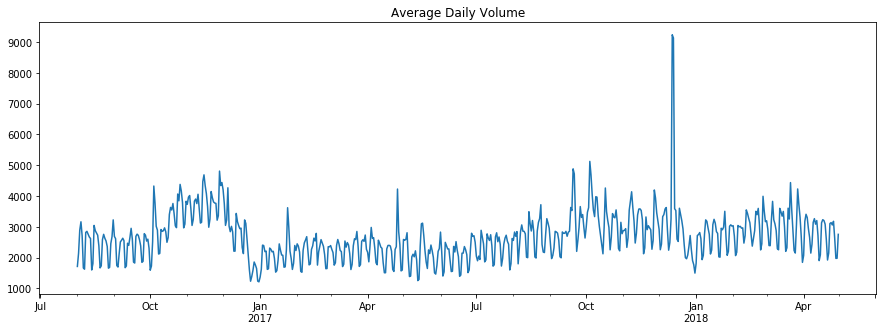

In [241]:
# There is an increase from Oct 2016 to Dec 2016 and Dec 2017, 
# which is probably due to the holiday season.

plt.subplots(figsize=(15,5))
daily_count = train_df.groupby('date')['Id'].count()
ts = pd.Series(daily_count.values, index=date_range('8/1/2016', '4/30/2018'))
ts.plot(title='Average Daily Volume')

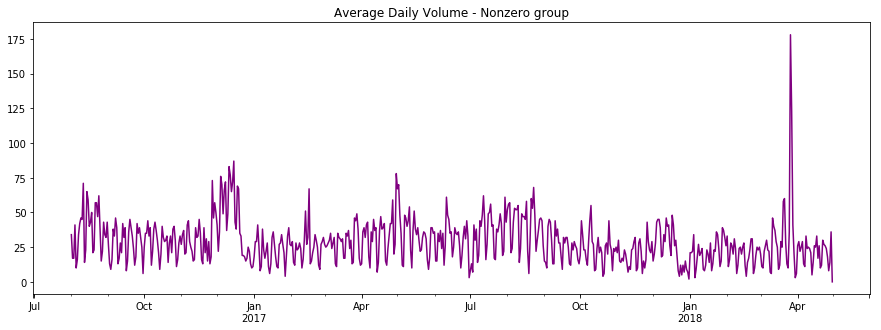

In [242]:
plt.subplots(figsize=(15,5))
daily_count = nonzero_df.groupby('date')['Id'].count()
daily_count.loc[20160803] = 0
daily_count.sort_index()
ts = pd.Series(daily_count.values, index=date_range('8/1/2016', '4/30/2018'))
ts.plot(title='Average Daily Volume - Nonzero group',color='purple')

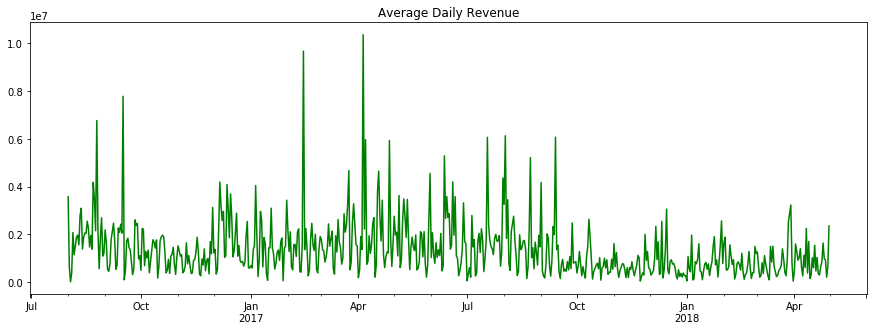

In [243]:
# The peaks of revenue are not consistent with that of volume.
plt.subplots(figsize=(15,5))
daily_rev = train_df.groupby('date')['revenue'].mean()
ts = pd.Series(daily_rev.values, index=date_range('8/1/2016', '4/30/2018'))
ts.plot(title='Average Daily Revenue',color='green')

#### visitNumber

Text(0.5,1,'average revenue per session')

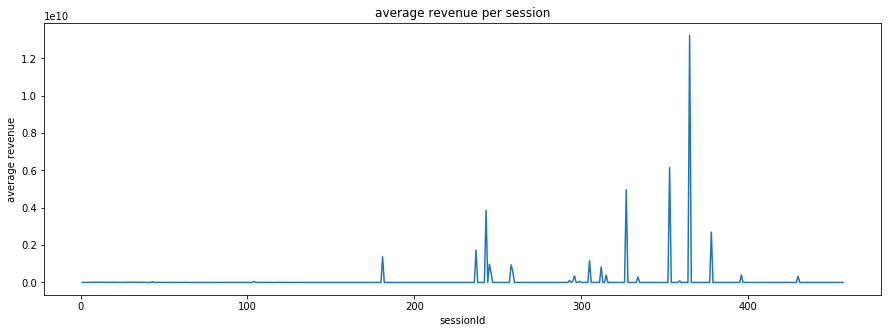

In [244]:
plt.subplots(figsize=(15,5))
vNum_rev = train_df.groupby('visitNumber')['revenue'].mean()
plt.plot(vNum_rev.index, vNum_rev)
plt.xlabel('sessionId')
plt.ylabel('average revenue')
plt.title('average revenue per session')